# Generating Annihilation Rates from Remote Cache of Particle Model
Tim Tyree<br>
11.23.2021

DONE: ported this ipynb to lib

In [1]:
from scipy.optimize import minimize

from lib.my_initialization import *
from lib import *
from lib.lib_care.measure.level_sets import comp_longest_level_set_and_smooth
%load_ext autoreload
%autoreload 2

import random,scipy
from scipy.interpolate import LinearNDInterpolator
from scipy.interpolate import CloughTocher2DInterpolator
import matplotlib as mpl #for colorbar
from scipy import stats
#DONE: hook this routine up to dask
#DONT: hook this routine up to dask_cuda
# import scanpy as sc
darkmode=False
if darkmode:
    # For darkmode plots
    from jupyterthemes import jtplot
    jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
#     theme=cuxfilter.themes.dark
#     #     theme=cuxfilter.themes.rapids
else:
    sns.set_style('white')
#     theme=cuxfilter.themes.light
import warnings
warnings.simplefilter("ignore", UserWarning)
%load_ext autoreload
%autoreload 2
# import cupy as cp
np.random.seed(42)
# cp.random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# def comp_rmse_via_interp(x, *args):
#     '''find a best r,kappa pair for a given a,D pair for a given full model'''
#     a,D,q_values,w_values,interp=args
#     r,kappa=x
#     #interpolate nu and M using interp
#     X=np.array([[r,kappa,a,D]])
#     yhat = interp(X)
#     nu=yhat[0,0]
#     M=yhat[0,1]
#     # M=yhat[0,2]
#     what_values=M*q_values**nu
#     rmse_full=np.sqrt(np.mean((what_values-w_values)**2))
#     return rmse_full

In [3]:
# def comp_mse_via_interp(x, *args):
#     '''find a best r,kappa pair for a given a,D pair for a given full model'''
#     a,D,q_values,w_values,interp=args
#     r,kappa=x
#     #interpolate nu and M using interp
#     X=np.array([[r,kappa,a,D]])
#     yhat = interp(X)
#     nu=yhat[0,0]
#     M=yhat[0,1]
#     # M=yhat[0,2]
#     what_values=M*q_values**nu
#     mse=np.mean((what_values-w_values)**2)
#     return mse

In [4]:
wjr=recall_powerlaw_fits_to_full_models()
print(*wjr)

fk_pbc lr_pbc fk_ncbc lr_ncbc


In [5]:
#apparent measurements
# #FK (a_hat short timescale, D_hat long timescale)
a_hat_FK=7.3923;
D_hat_FK=0.365238#;num_pairs=25;tavg_step=5;tavg1_max=15;tavg2_max=15

a_hat_FK_long = 1.509282#+/-0.178827 cm^2/s, tmax=90
a_hat_FK_vlong = 1.604153#+/-0.040173 cm^2/s
# tavg2=14 ms, num_samples=19087, tmin=0, tmax=300 ms


#msr from the particle model
# npz_dir_FK='/home/timothytyree/Documents/GitHub/bgmc/python/data/control_data/arrays/control_a_7.3923_D_0.365238.npz'#csv'
#msr from the full model
# msr_dir_fk='/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/msr_fk_boostrapped_tavg2_14.0_n_19087_a_1.6_tmax_300.csv'

#LR (a_hat short timescale, D_hat long timescale)
a_hat_LR=8.595
D_hat_LR=0.586055#;num_pairs=25;tavg_step=5;tavg1_max=15;tavg2_max=15
#msr from the particle model
# npz_dir_LR='/home/timothytyree/Documents/GitHub/bgmc/python/data/control_data/arrays/control_a_8.595_D_0.586055.npz'#.csv'
a_hat_LR_long = 3.535902#+/-0.312245 cm^2/s, tmax=60

# load the resulting table of powerlaw fits and train interpolation to estimate annihilation rates from the particle model

In [6]:
#DONE: combine the following into 'recall_particle_model_interp():'
#TODO: test ^that for figure 3
#TODO: send to lib
#TODO: test from lib for figure 2

In [7]:
#define constant parameters
reflect=0
force_code=2
set_second=0
no_attraction=0
no_repulsion=0
# kappa=100
L=10
testing=False #True yields an extra runtimme of ~2 minutes

In [10]:
# #neighbor-only forces
# input_fn=f"/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_19_all_powerlaw_fits.csv"
# neighbor=1
# vector-summed forces
input_fn=f"/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_17_all_powerlaw_fits.csv"
neighbor=0

#TODO: aggregate powerlaw fits with neighbor-only or vector-summed fits 
#TODO: aggregate powerlaw fits with D>=1.2


df=pd.read_csv(input_fn)
print(f"estimated runtime is ~{20+120*int(testing)} seconds...")
#query the DataFrame
query =(df.set_second==set_second)&(df.reflect==reflect)
query&=(df.no_repulsion==no_repulsion)&(df.no_attraction==no_attraction)
query&=(df.neighbor==neighbor)&(df.force_code==force_code)
# query&=df.r==r
# query&=df.kappa==kappa
# query&=df.D==D
query&=df.L==L
# query&=df.varkappa==varkappa
dg=df[query]

#define parameters to be varied
# input_cols=['r','D','varkappa']#
input_cols=['r','kappa','varkappa','D']#
# output_cols=['m','Delta_m','M','Delta_M']#2 minute runtime
output_cols=['m','M']#2.75 minute runtime paradoxically...
#inputs:dg,input_cols,output_col
#output: fitted model

Xall=dg[input_cols].values 
yall=dg[output_cols].values

estimated runtime is ~20 seconds...


In [11]:
Xall.shape

(17988, 4)

In [12]:
X=Xall.copy()
y=yall.copy()
m = len(y) # number of training examples
print(f'number of training examples is {m:d}.')

interp = LinearNDInterpolator(X, y)
# interp = CloughTocher2DInterpolator(X, y)
print(f"training complete!")
if testing:
    yhat = interp(X)
    print(f"shape of X {X.shape} --> shape of y=yhat {yhat.shape}")

    rmse=np.sqrt(np.mean((yhat-y)**2))
    print(f"the rmse of simple interpolation is {rmse:.4f}")

number of training examples is 17988.
training complete!


# Generate plots of annihilation rates for each apparent parameter setting

## Luo-Rudy

In [13]:
model_name='lr_pbc'
c='C1'
# model_name='fk_pbc'
# c='C0'

#compute annihilation rates 
nu_full=wjr[model_name]['m']
M_full=wjr[model_name]['M']
q_values=np.linspace(0,1,20)
w_values=M_full*q_values**nu_full

if model_name=='lr_pbc':
    model_name_string='Luo-Rudy'
elif model_name=='fk_pbc':
    model_name_string='Fenton-Karma'
else:
    model_name_string='??'

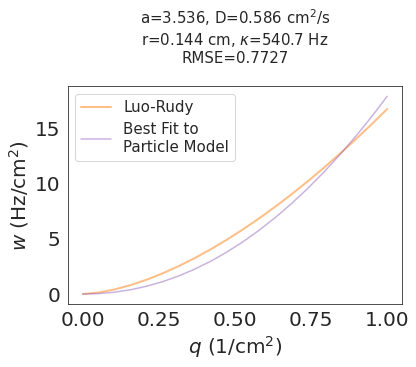

a=3.535902, D=0.586055, r=0.14354451445429925, kappa=540.6792290189508, rmse=0.772652033578332


In [14]:
a=a_hat_LR_long
# a=a_hat_LR
D=D_hat_LR
#find a best r,kappa pair for a given a,D pair for a given full model
args=a,D,q_values,w_values,interp
bnds = ((1e-3, 2), (1e2, 1e4))
x0 = (0.1, 500)
res = minimize(comp_rmse_via_interp, (0.1, 500), args, method='Nelder-Mead', bounds=bnds,tol=1e-3)
mse=comp_mse_via_interp(res.x, *args)
rmse=np.sqrt(mse)
# rmse=comp_rmse_via_interp(res.x, *args)

#compute the resulting annihilation rates
r=res.x[0]
kappa=res.x[1]
X=np.array([[r,kappa,a,D]])
yhat = interp(X)
nu=yhat[0,0]
M=yhat[0,1]
# M=yhat[0,2]
what_values=M*q_values**nu

#plot the result over the original annihilation rates
title=f'a={a:.3f}, D={D:.3f}'+r' cm$^2$/s'+f"\nr={r:.3f} cm, "+r'$\kappa$'+f'={kappa:.1f} Hz\nRMSE={rmse:.4f}\n'
plt.plot(q_values,w_values,c=c,label=model_name_string,alpha=0.5,lw=2)
plt.plot(q_values,what_values,c='C4',label='Best Fit to\nParticle Model',alpha=0.5)
format_plot(ax=plt.gca(),xlabel=r'$q$ (1/cm$^2$)',ylabel=r'$w$ (Hz/cm$^2$)')
plt.legend(fontsize=15)
plt.title(title,fontsize=15)
plt.show()
print(f"a={a}, D={D}, r={r}, kappa={kappa}, rmse={rmse}")

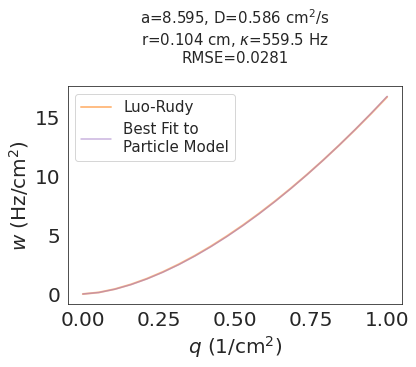

a=8.595, D=0.586055, r=0.10413888309470609, kappa=559.500160485693, rmse=0.028075538795257697


In [15]:
# a=a_hat_LR_long
a=a_hat_LR
D=D_hat_LR
#find a best r,kappa pair for a given a,D pair for a given full model
args=a,D,q_values,w_values,interp
bnds = ((1e-3, 2), (1e2, 1e4))
x0 = (0.1, 500)
res = minimize(comp_rmse_via_interp, (0.1, 500), args, method='Nelder-Mead', bounds=bnds,tol=1e-3)
mse=comp_mse_via_interp(res.x, *args)
rmse=np.sqrt(mse)
# rmse=comp_rmse_via_interp(res.x, *args)


#compute the resulting annihilation rates
r=res.x[0]
kappa=res.x[1]
X=np.array([[r,kappa,a,D]])
yhat = interp(X)
nu=yhat[0,0]
M=yhat[0,1]
# M=yhat[0,2]
what_values=M*q_values**nu

#plot the result over the original annihilation rates
title=f'a={a:.3f}, D={D:.3f}'+r' cm$^2$/s'+f"\nr={r:.3f} cm, "+r'$\kappa$'+f'={kappa:.1f} Hz\nRMSE={rmse:.4f}\n'
plt.plot(q_values,w_values,c=c,label=model_name_string,alpha=0.5,lw=2)
plt.plot(q_values,what_values,c='C4',label='Best Fit to\nParticle Model',alpha=0.5)
format_plot(ax=plt.gca(),xlabel=r'$q$ (1/cm$^2$)',ylabel=r'$w$ (Hz/cm$^2$)')
plt.legend(fontsize=15)
plt.title(title,fontsize=15)
plt.show()
print(f"a={a}, D={D}, r={r}, kappa={kappa}, rmse={rmse}")

## Fenton-Karma

In [27]:
# model_name='lr_pbc'
# c='C1'
model_name='fk_pbc'
c='C0'

#compute annihilation rates 
nu_full=wjr[model_name]['m']
M_full=wjr[model_name]['M']
q_values=np.linspace(0,1,20)
w_values=M_full*q_values**nu_full

if model_name=='lr_pbc':
    model_name_string='Luo-Rudy'
elif model_name=='fk_pbc':
    model_name_string='Fenton-Karma'
else:
    model_name_string='??'

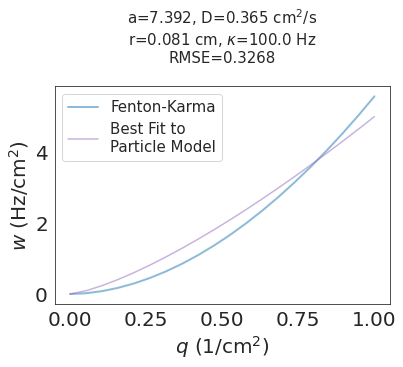

a=7.3923, D=0.365238, r=0.08121112364322852, kappa=100.0, rmse=0.32680961856525387


In [28]:
a=a_hat_FK
D=D_hat_FK
#find a best r,kappa pair for a given a,D pair for a given full model
args=a,D,q_values,w_values,interp
bnds = ((1e-3, 2), (1e2, 1e4))
x0 = (0.1, 500)
res = minimize(comp_rmse_via_interp, (0.1, 500), args, method='Nelder-Mead', bounds=bnds,tol=1e-3)
mse=comp_mse_via_interp(res.x, *args)
rmse=np.sqrt(mse)
# rmse=comp_rmse_via_interp(res.x, *args)

#compute the resulting annihilation rates
r=res.x[0]
kappa=res.x[1]
X=np.array([[r,kappa,a,D]])
yhat = interp(X)
nu=yhat[0,0]
M=yhat[0,1]
# M=yhat[0,2]
what_values=M*q_values**nu

#plot the result over the original annihilation rates
title=f'a={a:.3f}, D={D:.3f}'+r' cm$^2$/s'+f"\nr={r:.3f} cm, "+r'$\kappa$'+f'={kappa:.1f} Hz\nRMSE={rmse:.4f}\n'
plt.plot(q_values,w_values,c=c,label=model_name_string,alpha=0.5,lw=2)
plt.plot(q_values,what_values,c='C4',label='Best Fit to\nParticle Model',alpha=0.5)
format_plot(ax=plt.gca(),xlabel=r'$q$ (1/cm$^2$)',ylabel=r'$w$ (Hz/cm$^2$)')
plt.legend(fontsize=15)
plt.title(title,fontsize=15)
plt.show()
print(f"a={a}, D={D}, r={r}, kappa={kappa}, rmse={rmse}")

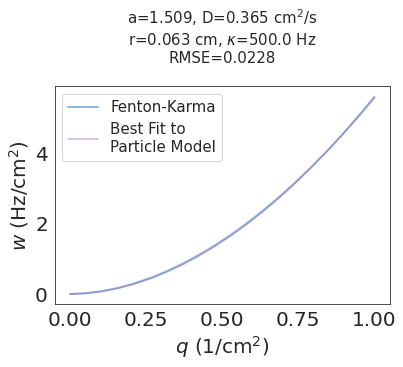

a=1.509282, D=0.365238, r=0.062645667890564, kappa=499.9996641402718, rmse=0.022790941708783506


In [29]:
a=a_hat_FK_long
D=D_hat_FK
#find a best r,kappa pair for a given a,D pair for a given full model
args=a,D,q_values,w_values,interp
bnds = ((1e-3, 2), (1e2, 1e4))
x0 = (0.1, 500)
res = minimize(comp_rmse_via_interp, (0.1, 500), args, method='Nelder-Mead', bounds=bnds,tol=1e-3)
mse=comp_mse_via_interp(res.x, *args)
rmse=np.sqrt(mse)
# rmse=comp_rmse_via_interp(res.x, *args)

#compute the resulting annihilation rates
r=res.x[0]
kappa=res.x[1]
X=np.array([[r,kappa,a,D]])
yhat = interp(X)
nu=yhat[0,0]
M=yhat[0,1]
# M=yhat[0,2]
what_values=M*q_values**nu

#plot the result over the original annihilation rates
title=f'a={a:.3f}, D={D:.3f}'+r' cm$^2$/s'+f"\nr={r:.3f} cm, "+r'$\kappa$'+f'={kappa:.1f} Hz\nRMSE={rmse:.4f}\n'
plt.plot(q_values,w_values,c=c,label=model_name_string,alpha=0.5,lw=2)
plt.plot(q_values,what_values,c='C4',label='Best Fit to\nParticle Model',alpha=0.5)
format_plot(ax=plt.gca(),xlabel=r'$q$ (1/cm$^2$)',ylabel=r'$w$ (Hz/cm$^2$)')
plt.legend(fontsize=15)
plt.title(title,fontsize=15)
plt.show()
print(f"a={a}, D={D}, r={r}, kappa={kappa}, rmse={rmse}")

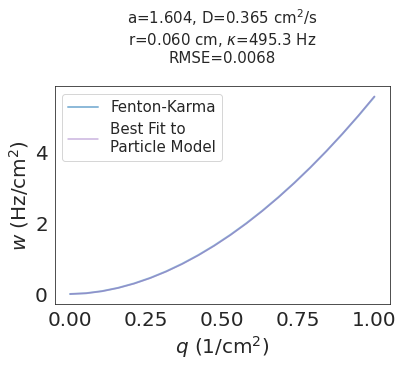

a=1.604153, D=0.365238, r=0.06045948522530842, kappa=495.2658318951493, rmse=0.006797222653889483


In [30]:
a=a_hat_FK_vlong
D=D_hat_FK
#find a best r,kappa pair for a given a,D pair for a given full model
args=a,D,q_values,w_values,interp
bnds = ((1e-3, 2), (1e2, 1e4))
x0 = (0.1, 500)
res = minimize(comp_rmse_via_interp, (0.1, 500), args, method='Nelder-Mead', bounds=bnds,tol=1e-3)
mse=comp_mse_via_interp(res.x, *args)
rmse=np.sqrt(mse)
# rmse=comp_rmse_via_interp(res.x, *args)

#compute the resulting annihilation rates
r=res.x[0]
kappa=res.x[1]
X=np.array([[r,kappa,a,D]])
yhat = interp(X)
nu=yhat[0,0]
M=yhat[0,1]
# M=yhat[0,2]
what_values=M*q_values**nu

#plot the result over the original annihilation rates
title=f'a={a:.3f}, D={D:.3f}'+r' cm$^2$/s'+f"\nr={r:.3f} cm, "+r'$\kappa$'+f'={kappa:.1f} Hz\nRMSE={rmse:.4f}\n'
plt.plot(q_values,w_values,c=c,label=model_name_string,alpha=0.5,lw=2)
plt.plot(q_values,what_values,c='C4',label='Best Fit to\nParticle Model',alpha=0.5)
format_plot(ax=plt.gca(),xlabel=r'$q$ (1/cm$^2$)',ylabel=r'$w$ (Hz/cm$^2$)')
plt.legend(fontsize=15)
plt.title(title,fontsize=15)
plt.show()
print(f"a={a}, D={D}, r={r}, kappa={kappa}, rmse={rmse}")

# TODO: Generate plots of annihilation rates for a given pair of parameter settings fit to the full models

In [4]:
minimize

NameError: name 'minimize' is not defined

In [20]:
# def PlotParticlModelAnnihilationRateFit(model_name,c,a,D,wjr,interp,ax=None,**kwargs):
#     """
#     Example Usage:
#     interp=recall_particle_model_interp()
#     dict_out=PlotParticlModelAnnihilationRateFit(model_name,c,a,D,wjr,interp,ax=None)
#     """
#     if ax is None:
#         ax=plt.gca()
#     plt.sca(ax)
#     #compute annihilation rates 
#     nu_full=wjr[model_name]['m']
#     M_full=wjr[model_name]['M']
#     q_values=np.linspace(0,1,20)
#     w_values=M_full*q_values**nu_full

#     if model_name=='lr_pbc':
#         model_name_string='Luo-Rudy'
#     elif model_name=='fk_pbc':
#         model_name_string='Fenton-Karma'
#     else:
#         model_name_string='??'

#     #find a best r,kappa pair for a given a,D pair for a given full model
#     args=a,D,q_values,w_values,interp
#     bnds = ((1e-3, 2), (1e2, 1e4))
#     x0 = (0.1, 500)
#     res = minimize(comp_rmse_via_interp, (0.1, 500), args, method='Nelder-Mead', bounds=bnds,tol=1e-3)
#     mse=comp_mse_via_interp(res.x, *args)
#     rmse=np.sqrt(mse)
# #     rmse=comp_rmse_via_interp(res.x, *args)
# #     # print(f"a={a}, D={D}, r={r}, kappa={kappa}, rmse={rmse}")

#     #compute the resulting annihilation rates
#     r=res.x[0]
#     kappa=res.x[1]
#     X=np.array([[r,kappa,a,D]])
#     yhat = interp(X)
#     nu=yhat[0,0]
#     M=yhat[0,1]
#     # M=yhat[0,2]
#     what_values=M*q_values**nu

#     #plot the result over the original annihilation rates
#     title=f'a={a:.3f}, D={D:.3f}'+r' cm$^2$/s'+f"\nr={r:.3f} cm, "+r'$\kappa$'+f'={kappa:.1f} Hz\nRMSE={rmse:.4f}\n'
#     plt.plot(q_values,w_values,c='k',alpha=0.1,lw=3)
#     plt.plot(q_values,what_values,'--',c=c,label=f'Fit to\n{model_name_string}',alpha=1)
#     #plt.plot(q_values,w_values,c=c,label=model_name_string,alpha=0.5,lw=2)
#     #plt.plot(q_values,what_values,c='C4',label='Fit to\nParticle Model',alpha=0.5)
#     format_plot(ax=plt.gca(),xlabel=r'$q$ (1/cm$^2$)',ylabel=r'$w$ (Hz/cm$^2$)')
#     plt.legend(fontsize=15)
#     plt.title(title,fontsize=15)
#     print(f"a={a}, D={D}, r={r}, kappa={kappa}, rmse={rmse}")
#     return dict(r=r,kappa=kappa,nu=nu,M=M,rmse=rmse,res=res)
    
def PlotParticlModelAnnihilationFit(model_name,c,a,D,wjr,ax=None,**kwargs):
    """
    
    """
    if ax is None:
        ax=plt.gca()
    plt.sca(ax)
    #compute annihilation rates 
    nu_full=wjr[model_name]['m']
    M_full=wjr[model_name]['M']
    q_values=np.linspace(0,1,20)
    w_values=M_full*q_values**nu_full

    if model_name=='lr_pbc':
        model_name_string='Luo-Rudy'
    elif model_name=='fk_pbc':
        model_name_string='Fenton-Karma'
    else:
        model_name_string='??'

    #find a best r,kappa pair for a given a,D pair for a given full model
    args=a,D,q_values,w_values,interp
    bnds = ((1e-3, 2), (1e2, 1e4))
    x0 = (0.1, 500)
    res = minimize(comp_rmse_via_interp, (0.1, 500), args, method='Nelder-Mead', bounds=bnds,tol=1e-3)
    mse=comp_mse_via_interp(res.x, *args)
    rmse=np.sqrt(mse)
#     rmse=comp_rmse_via_interp(res.x, *args)
#     # print(f"a={a}, D={D}, r={r}, kappa={kappa}, rmse={rmse}")

    #compute the resulting annihilation rates
    r=res.x[0]
    kappa=res.x[1]
    X=np.array([[r,kappa,a,D]])
    yhat = interp(X)
    nu=yhat[0,0]
    M=yhat[0,1]
    # M=yhat[0,2]
    what_values=M*q_values**nu

    #plot the result over the original annihilation rates
    title=f'a={a:.3f}, D={D:.3f}'+r' cm$^2$/s'+f"\nr={r:.3f} cm, "+r'$\kappa$'+f'={kappa:.1f} Hz\nRMSE={rmse:.4f}\n'
    plt.plot(q_values,w_values,c='k',alpha=0.1,lw=3)
    plt.plot(q_values,what_values,'--',c=c,label=f'Fit to\n{model_name_string}',alpha=1)
    #plt.plot(q_values,w_values,c=c,label=model_name_string,alpha=0.5,lw=2)
    #plt.plot(q_values,what_values,c='C4',label='Fit to\nParticle Model',alpha=0.5)
    format_plot(ax=plt.gca(),xlabel=r'$q$ (1/cm$^2$)',ylabel=r'$w$ (Hz/cm$^2$)')
    plt.legend(fontsize=15)
    plt.title(title,fontsize=15)
    print(f"a={a}, D={D}, r={r}, kappa={kappa}, rmse={rmse}")
    return dict(r=r,kappa=kappa,nu=nu,M=M,rmse=rmse,res=res)

In [21]:
#visual estimates from the oscillatory model
D_osc_FK=0.8
D_osc_LR=1.2
a_osc_FK=1.6
a_osc_LR=8.5/2
a_hat_osc_FK=1.60
a_hatosc_LR=2.24

a=1.6, D=0.8, r=0.05461074284069874, kappa=599.9999882644564, rmse=0.013503513262027712
a=4.25, D=1.2, r=0.1, kappa=500.0, rmse=nan


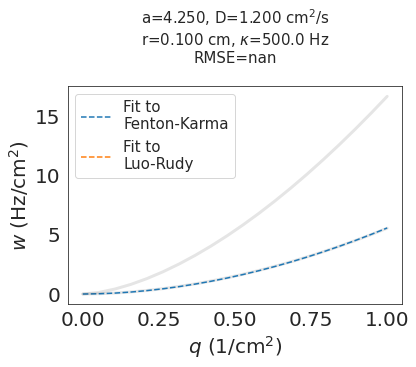

In [22]:
model_name1='fk_pbc'
c1='C0'
model_name2='lr_pbc'
c2='C1'
a1=a_osc_FK; D1=D_osc_FK;
a2=a_osc_LR; D2=D_osc_LR;
kwargs={}
retval1= PlotParticlModelAnnihilationFit(model_name1,c1,a1,D1,wjr,ax=None,**kwargs)
retval2= PlotParticlModelAnnihilationFit(model_name2,c2,a2,D2,wjr,ax=None,**kwargs)
plt.show()

In [23]:
# model_name,c,a,D=model_name1,c1,a1,D1
model_name,c,a,D=model_name2,c2,a2,D2

# if ax is None:
#     ax=plt.gca()
# plt.sca(ax)
#compute annihilation rates 
nu_full=wjr[model_name]['m']
M_full=wjr[model_name]['M']
q_values=np.linspace(0,1,20)
w_values=M_full*q_values**nu_full

if model_name=='lr_pbc':
    model_name_string='Luo-Rudy'
elif model_name=='fk_pbc':
    model_name_string='Fenton-Karma'
else:
    model_name_string='??'

#find a best r,kappa pair for a given a,D pair for a given full model
args=a,D,q_values,w_values,interp
bnds = ((1e-3, 2), (1e2, 1e4))
x0 = (0.1, 500)
res = minimize(comp_rmse_via_interp, (0.1, 500), args, method='Nelder-Mead', bounds=bnds,tol=1e-3)
mse=comp_mse_via_interp(res.x, *args)
rmse=np.sqrt(mse)
#     rmse=comp_rmse_via_interp(res.x, *args)

#compute the resulting annihilation rates
r=res.x[0]
kappa=res.x[1]
X=np.array([[r,kappa,a,D]])
yhat = interp(X)
nu=yhat[0,0]
M=yhat[0,1]
# M=yhat[0,2]
what_values=M*q_values**nu


print(f"a={a}, D={D}, r={r}, kappa={kappa}, rmse={rmse}")

a=4.25, D=1.2, r=0.1, kappa=500.0, rmse=nan


In [24]:
args

(4.25,
 1.2,
 array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
        0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
        0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
        0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ]),
 array([ 0.        ,  0.13477529,  0.41933762,  0.81456018,  1.3047202 ,
         1.8802387 ,  2.53440918,  3.26216458,  4.05948503,  4.92307076,
         5.85014382,  6.8383196 ,  7.88551912,  8.9899069 , 10.14984533,
        11.36386037, 12.6306151 , 13.94888904, 15.31756157, 16.73559858]),
 <scipy.interpolate.interpnd.LinearNDInterpolator at 0x7fbb20115a90>)

In [25]:
res = minimize(comp_rmse_via_interp, (0.1, 500), args, method='trust-krylov', bounds=bnds,tol=None)
mse=comp_mse_via_interp(res.x, *args)
print(f"mse={mse:.4f}")

ValueError: ('Jacobian is required for trust region ', 'exact minimization.')


__Methods Available__
- 'Nelder-Mead' :ref:`(see here) <optimize.minimize-neldermead>`
- 'Powell'      :ref:`(see here) <optimize.minimize-powell>`
- 'CG'          :ref:`(see here) <optimize.minimize-cg>`
- 'BFGS'        :ref:`(see here) <optimize.minimize-bfgs>`
- 'Newton-CG'   :ref:`(see here) <optimize.minimize-newtoncg>`
- 'L-BFGS-B'    :ref:`(see here) <optimize.minimize-lbfgsb>`
- 'TNC'         :ref:`(see here) <optimize.minimize-tnc>`
- 'COBYLA'      :ref:`(see here) <optimize.minimize-cobyla>`
- 'SLSQP'       :ref:`(see here) <optimize.minimize-slsqp>`
- 'trust-constr':ref:`(see here) <optimize.minimize-trustconstr>`
- 'dogleg'      :ref:`(see here) <optimize.minimize-dogleg>`
- 'trust-ncg'   :ref:`(see here) <optimize.minimize-trustncg>`
- 'trust-exact' :ref:`(see here) <optimize.minimize-trustexact>`
- 'trust-krylov' :ref:`(see here) <optimize.minimize-trustkrylov>`
- custom - a callable object (added in version 0.14.0),
  see below for description.

__Interacting Particle Models that could potentially explain the apparent disagreement for the Luo-Rudy model at long time scales__

Considering $C=\sqrt{4D}$,

$$
dR = \frac{-2a}{R}dt + CdW(t).
$$

The attracting inverse_powerlaw_model be changed to the fractional_powerlaw_model:

$$
dR = \frac{-2a}{R^b}dt + CdW(t)
$$

for $b=0.716(1)$ (LR) or $b=0.797(2)$ (FK).


The attracting inverse_powerlaw_model be changed to the attracting and repelling oscillatory_powerlaw_model:

$$
dR = \frac{-2a}{R}\cos(\omega t + \phi)dt + CdW(t)
$$

for $\omega=2\pi/T$ for $T=100$ ms (LR) or for $T=90$ ms (FK).  To keep the model simple, $\phi=\phi_0$ is a phase constant.